In [1]:
#upper air plots for midwest from 12/12/2022 to 12/16/2022

In [10]:
import numpy as np
from datetime import datetime, timedelta

from UpperAirFunctions import get_raobs , select_press

import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import StationPlot
from metpy.interpolate import interpolate_to_grid, remove_nan_observations

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from siphon.simplewebservice.iastate import IAStateUpperAir
from metpy.io import add_station_lat_lon

In [12]:
year = 2022
month = 12
hour = 0

dt = datetime (year,month,17,hour)
data = get_raobs(dt)
data_500 = select_press(data,500)


HTTPError: Error accessing http://mesonet.agron.iastate.edu/json/raob.py?ts=202212170000
Server Error (422: [{'type': 'missing', 'loc': ('query', 'station'), 'msg': 'Field required', 'input': {'ts': '202212170000'}, 'url': 'https://errors.pydantic.dev/2.7/v/missing'}])

NameError: name 'data' is not defined

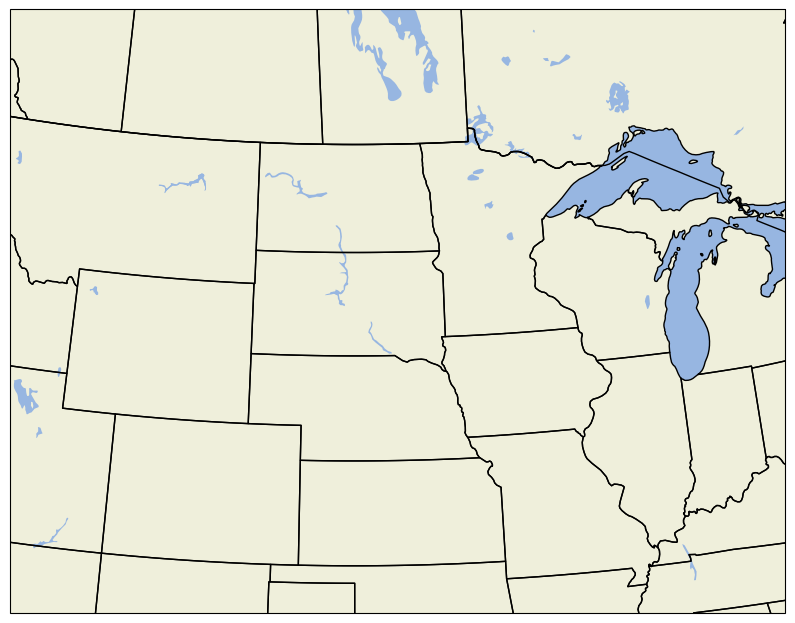

In [8]:
proj = ccrs.LambertConformal(central_longitude=-100,central_latitude=35)
#create 10" x 10" figure with a dpi=100
fig = plt.figure(figsize = (10,10), dpi =100)
#add subplot with projection
ax = fig.add_subplot(1,1,1,projection=proj)

#add elements to make map more useable
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)

ax.set_extent((-112, -85, 35, 52)) #for all of US (-120,-75, 23, 50) for upper midwest (-112, -85, 35, 52)
ax.scatter(data.longitude, data.latitude, transform=ccrs.PlateCarree(), marker = "", zorder = 9)
fig.tight_layout()

plots = StationPlot (ax, data_500["longitude"], data_500["latitude"], transform = ccrs.PlateCarree(),clip_on = True)

#temperature in red
plots.plot_parameter ((-1,1), data_500["temperature"].values, color = 'red')
#dewpoint DEPRESSION in dark green
plots.plot_parameter ((-1,-1), data_500["temperature"] - data_500["dewpoint"].values, color = 'darkgreen')
#height (need to format to be the first 3 digits)
plots.plot_parameter((1.5,1), data_500["height"], color = 'black',formatter = lambda p: format (10*p, ".0f")[:3])
#station ID in dark blue
plots.plot_text ((1.5,-1), data_500["station"], color = 'darkblue')
#wind in black
plots.plot_barb (data_500["u_wind"].values, data_500["v_wind"].values)

#convert the data to x, y, and z locations on the projected map
x,y,z = proj.transform_points(ccrs.PlateCarree(),data_500["longitude"].values, data_500["latitude"].values).T
#remove nans
mask = ~np.isnan(x)
#interpolate the data to a grid
grdx, grdy, hght = interpolate_to_grid(x[mask],y[mask],data_500["height"].values[mask], interp_type = "cressman", search_radius = 1000000,
                                       minimum_neighbors = 3, hres = 100000)

clevs = np.arange(4600,6000, 30)
#print(clevs)
ds = ax.contour(grdx,grdy, hght,clevs, colors = "black")
ax.clabel(ds,inline = True,zorder = 10,fmt = lambda v: format(v,".0f")[:3])
#add a title with the date
plt.title(f'{dt.strftime("%Y%m%d_%HZ")}\n500MB Analysis')

imgName = f'{dt.strftime("UpperAir_%Y%m%d_%Hz.png")}'

plt.savefig(imgName)